# EN.625.670 Data Mining

## Final Project - Neural Network Classifier on MNIST dataset

**Zhengcheng Gu**

Dec. 20th, 2018

## 0. Switch of Dataset

After a few research and experiment, I found that the previous Wine Quality problem is less clear constructed. As the purpose of this project is to practice and demonstrate the algorithm (neural network) learned in course, I decided to switch to one of famous dataset on classification problem - MNIST dataset [1].


## 1. Introduction

The MNIST dataset is a dataset for handwritten digits. The dataset can be accessed via (http://yann.lecun.com/exdb/mnist/)

The description of the dataset [1]:

```
The MNIST database of handwritten digits, available from this page, has a training set 
of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set 
available from NIST. The digits have been size-normalized and centered in a fixed-size 
image.
```

The goal of the project is to build a classifier with Neural Network for classifying the handwritten data. The neural network will be implemented from scratch with following key features:

* Support multiple hidden layer
* Support different size among the hidden layer
* Backpropogating with gradient descent

This notebook will be a note of step-by-step implementation history.


## 2. Dataset

### 2.1 Access the data

The dataset can be accessed by visiting: http://yann.lecun.com/exdb/mnist/. The dataset consists four separated files. 

```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```


### 2.2 Load the data

The data is preprocessed data. The file is not in any standard picture format. As described at the data source, the training set contains 60000 examples, and the test set 10000 examples. Here is the detailed description of the file structure [1].

```
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  60000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 
0 means background (white), 255 means foreground (black).

TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  10000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  10000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 
0 means background (white), 255 means foreground (black). 
  
```

After a few failed attempt, I switched to a library called: mlxtend (http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)

The library will work with unziped data, therefore, all the .gz data are unziped before running the script.


In [2]:
# Load Data

import os
import numpy as np
import pandas as pd
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt

np.random.seed(1)

trainset_X, trainset_y = loadlocal_mnist(images_path='train-images-idx3-ubyte', 
                                   labels_path='train-labels-idx1-ubyte')
test_X, test_y = loadlocal_mnist(images_path='t10k-images-idx3-ubyte', 
                                   labels_path='t10k-labels-idx1-ubyte')

### 2.3 Quick validation of imported data

A quick exam on test_y label

In [3]:
print(test_y.view())

[7 2 1 ... 4 5 6]


Print the corresponing image in test_X

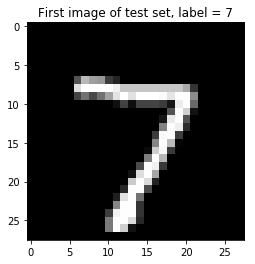

In [4]:
# Reshape the first row of the test_X into 28x28 matrix
img = np.reshape(test_X[0], (28, 28))
# Plot the image
plt.subplot(1,1,1)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("First image of test set, label = 7")
plt.show()

As shown on the quick exam, the data have been properly imported as four Numpy arrays:

```
trainset_X - training data 
trainset_y - training labels
test_X  - test data
test_y  - test labels
```

### 2.4 Preprocessing

Before starting build the Neural Network, it's better to create a validation dataset.

In [5]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = \
train_test_split(trainset_X, trainset_y, test_size=0.2, random_state=1)

Now the data splited into 3 groups: train, validation and test.

```
train_X - training data 
train_y - training labels
valid_X - validation data
valid_y - validation labels
test_X  - test data
test_y  - test labels
```

In [6]:
train_X.shape

(48000, 784)

In [7]:
valid_X.shape

(12000, 784)

In [8]:
test_X.shape

(10000, 784)

## 3. Step-by-Step Neural Network Implementation

Artificial neural network (ANN) is a machine learning technic developed from perceptron idea. It's a collection of connected neurons with or without hidden layer(s). The ANN mimics the structure neural networks in the brain. 

An illustration of neural network with one hidden layer is shown as follow [2]:

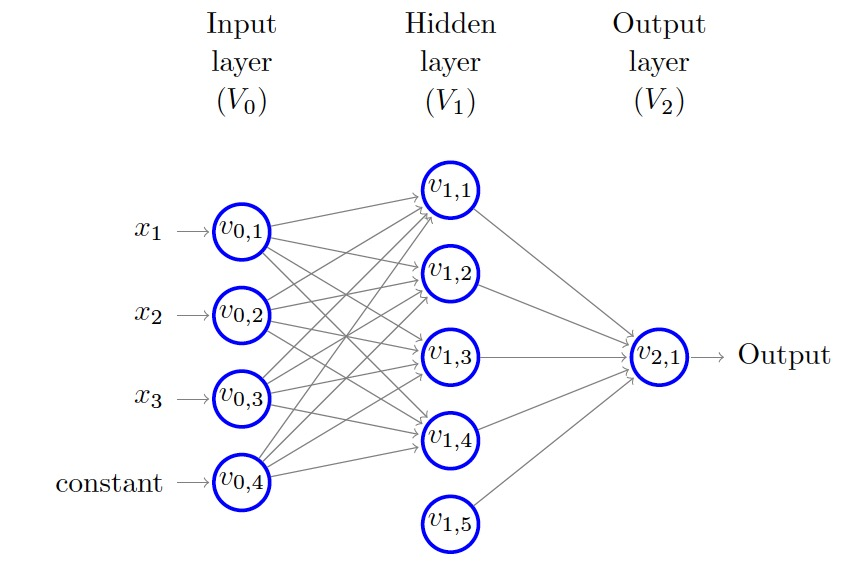

In [9]:
from IPython.display import Image
Image(filename='src/illustration_nn.png') 

---
The core learning algorithm used in this implementation is Stochastic Gradient Descent with back propogation. The main algorithm implemented in this project will be:

**Training**
``` 
initialize weight (w) and bias (w0) based on desired network structure.

for i in 1:iteration_maximum:
    * Feed forward with current weight and bias
    * Backward propogation
    * Update weight and bias
```

**Prediction**
```
Feed forward with final weight and bias
```

---

A few technic will also be implemented in order to improve the neural network implementation:

1. Regularization: L2 regularization is used to reduce the overfitting. It will be discussed in 3.11

2. Batch Training: Batch training is used to improve the efficiency of this implementation


### 3.1 Input and Output

For our neural network, the input layer will be the array of each image in training set. The image is a 28x28 matrix of grey scale in array shape. Therefore, the input layer will have $28 \times 28 = 784$ nodes.

The output layer's choice can be either 1 node or 10 nodes. I think 10 output nodes can be better with its estimated "likelihood". This will reveal for insight to the network's consideration to help on understanding.

### 3.2 Activation Function

The sigmoid function is chosen for activation function.

$$f(a) = \frac{1}{1+e^{-a}}$$

And the derivative of the Sigmoid function

$$f'(a) = f(a)(1-f(a))$$

In [10]:
# Implementation of Sigmoid function
def sigmoid(a):
    return 1.0/(1.0+np.exp(-a))

# First derivative of Sigmoid function
def d_sigmoid(a):
    return sigmoid(a)*(1 - sigmoid(a))

Verify the implemented sigmoid function

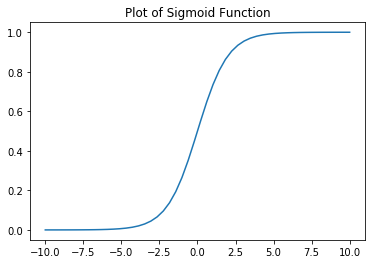

In [11]:
# Plot of Sigmoid function
temp_x = np.linspace(-10,10,num=50)
plt.subplot(1,1,1)
plt.plot(temp_x,sigmoid(temp_x))
plt.title("Plot of Sigmoid Function")
plt.show()

### 3.3 One-hot encoding

Because there is no order/preferred output, one-hot encoding is chosen to help on a better training. (https://www.ritchieng.com/machinelearning-one-hot-encoding/). 

Before the one-hot encoding, the label set is 

```
[3,2,4,...,4,6]
```

After the one-hot encoding, the label set will be

```
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
          .
          .
          .
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
```

The benefit of using one-hot encoding is to remove the hidden preference inside the labeling. Because 0-9 in this case are just some symbols instead of any magnitude meaning. It would be beneficial to remove this potential "bias".

In [12]:
from sklearn.preprocessing import OneHotEncoder

def onehotencoding(labels):
    if (len(labels.shape) < 2):
        labels = labels.reshape(-1, 1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(labels)
    onehotlabels = enc.transform(labels).toarray()
    return onehotlabels

Verify the implemented one-hot encoder

In [13]:
onehottest = onehotencoding(test_y)
print("Original Labels = ",test_y)

Original Labels =  [7 2 1 ... 4 5 6]


In [14]:
print("One-hot encoded labels = \n", onehottest)

One-hot encoded labels = 
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3.4 Define Network

This implementation is designed to be able to extend to multiple layers with variours nodes setup for each layer. Therefore a dictionary is needed to specify the hidden layer design:

```
{
  0: [
    "n_input",
    "n_nodes"
  ],
  1: [
    "n_input",
    "n_nodes"
  ]
  ...
}
```

For example, for a neural network with 48000 sample input with 784 features input. only 1 hidden layer with 300 nodes and 10 outputs. 

```
{
  0: [
    "784",
    "300"
  ],
  1: [
    "300",
    "10"
  ]
}
```

In [15]:
def gen_network_dim(n_feature, n_output, hidden):
    network_dim = {}
    
    # First layer
    network_dim[0] = [n_feature, hidden[0]]
    
    # Rest of hidden
    n_hidden = len(hidden)
    if (n_hidden > 1):
        for i in range(1,n_hidden):
            network_dim[i] = [hidden[i-1],hidden[i]]
            
    # Last layer
    network_dim[n_hidden] = [hidden[n_hidden-1], n_output]
    
    return network_dim

In [16]:
dim_test = gen_network_dim(784,10,[300,250])
print("The Network Structure is \n",dim_test)

The Network Structure is 
 {0: [784, 300], 1: [300, 250], 2: [250, 10]}


### 3.5 Weight and Bias for single layer

The weight ($w$) and bias ($w_0$) will the essential component of the neural network. These value needs to be initialized. 

* The weight need to be non-zero. In this case, the variance of each input variable is similar. Therefore, we can initilize the weight from an uniform distribution $U(-1,1)$.

* Dimension of the weight for each layer equal to [n_input, n_nodes]

* The bias are initilized to $0$.

* Dimension of the bias for each layer equal to [n_nodes]

In [17]:
def init_weight(dim1,dim2):
    return np.random.uniform(-1,1,(dim1,dim2))
    #return np.random.normal(loc = 0.0,scale = 0.1, size = (dim1,dim2)) 

def init_bias(dim1,dim2):
    return np.zeros(dim2)

Validate of initilization

In [18]:
test_init_weight = init_weight(2,3)
test_init_bias = init_bias(2,3)

print("2x3 Bias Matrix = \n",test_init_weight)

2x3 Bias Matrix = 
 [[-0.16595599  0.44064899 -0.99977125]
 [-0.39533485 -0.70648822 -0.81532281]]


In [19]:
print("Corresponding Bias Vector = \n",test_init_bias)

Corresponding Bias Vector = 
 [0. 0. 0.]


### 3.6 Build Weight and Bias Matrix

Once the method of network definition is nailed. The dimension of the network created by "gen_network_dim()" will be used to generate the weight and bias matrix for a multiple hidden layer neural network.

In [20]:
def init_w_and_w0_matrix(dim):
    w_matrix = {}
    w0_matrix = {}
    for key, value in dim.items():
        w_matrix[key] = init_weight(value[0],value[1])
        w0_matrix[key] = init_bias(value[0],value[1])
    return w_matrix, w0_matrix

In [21]:
w,w0 = init_w_and_w0_matrix(dim_test)

print("Dimension of the weight matrix")
print({key: [len(value),len(value[0])]  for key, value in w.items()})

Dimension of the weight matrix
{0: [784, 300], 1: [300, 250], 2: [250, 10]}


In [22]:
print("Dimension of the bias matrix")
print({key: [len(value)]  for key, value in w0.items()})

Dimension of the bias matrix
{0: [300], 1: [250], 2: [10]}


### 3.7 Single step Feedforward

Feedforward is the process that neural network consume the input and calculate the output. For a 3 layer neural network (input/hidden/output) with $784$ feature, $10$ output and $n$ hidden nodes. The feedforward process can be describe as:

**1. Input layer -> Hidden Layer**

According to chapter 6.2 Pattern classification, the net activation can be expressed as:

$$net_{j} = \sum_{i=1}^d x_i w_{ji} + w_{j0}$$

where, 
* $w_{ji}$ is the weight for node j with i's  feature
* $w_{j0}$ is the bias for node j

Input matrix X with shape (48000, 784)
* $w_h$ with shape $(784, n)$
* $w_{h0}$ with shape $(784, 1)$

Then the feedforward net activation for hidden layer is

$$net = X*w_h + w_{h0}$$

Then the output of hidden layer can be compute by

$$f(net) = Sigmoid(net)$$

**2. Hidden Layer -> Input Layer**

The process is exactly same as part 1 by using the output of hidden layer as input.

In [23]:
def single_forward_feed(X, w, w_0):
    net = np.dot(X,w) + w_0
    output = sigmoid(net)
    return net, output

### 3.8 Multiple Layer Forward Feeding

In order to cater the demand of forward feeding through multiple hidden layer, this method will resemble the "single_forward_feed()" method to complete the process of entire forward feeding.

In [24]:
def forward_feed(X,w_matrix,w0_matrix):
    z = {}
    a = {}
    
    z[0],a[0] = single_forward_feed(X, w_matrix[0], w0_matrix[0])
    
    for key in range(1,len(w_matrix)):
        z[key],a[key] = single_forward_feed(a[key-1], \
                                            w_matrix[key], w0_matrix[key])
    
    return z, a

### 3.9 Training Error

The training error can be calculated as:

$$J(w) = \frac{1}{n}\sum||t-z||^2$$

where 
* $z$ is the output of output layer
* $t$ is the target

In [25]:
from numpy.linalg import norm

def calc_training_error(output, target):
    return np.sum(norm(target - output))/len(output)

Validation of training error method

In [26]:
o = np.array([1,5])
t = np.array([1,2])
print(calc_training_error(o,t))

1.5


### 3.10 Backpropagation

The algorithm for searching optimal weight and bias is stochastic gradient descent (SGD) with backpropagation. The algorithm is based on P278 on Understanding Machine Learning: From Theory to Algorithms[3].

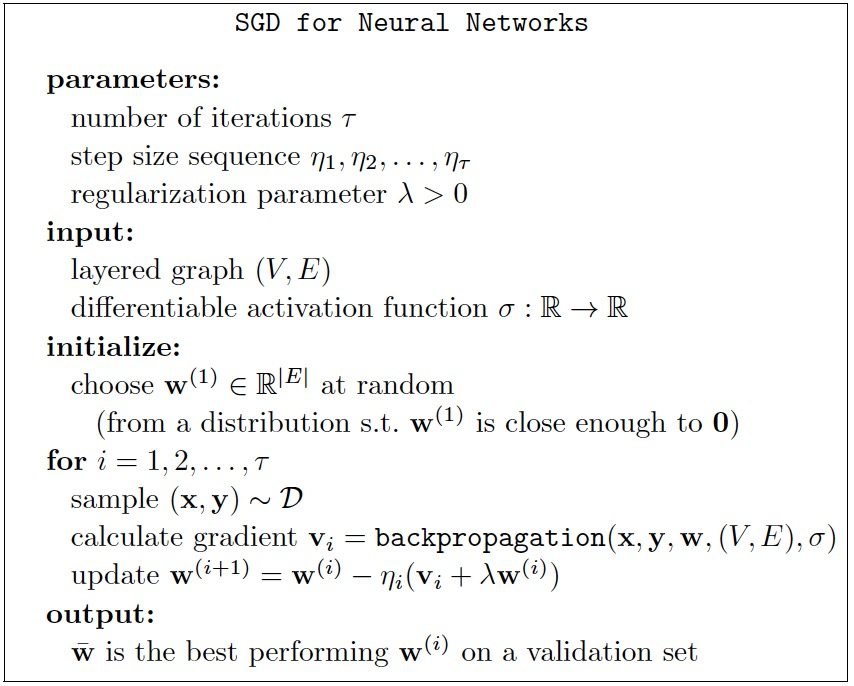

In [27]:
from IPython.display import Image
Image(filename='src/SGD.png') 

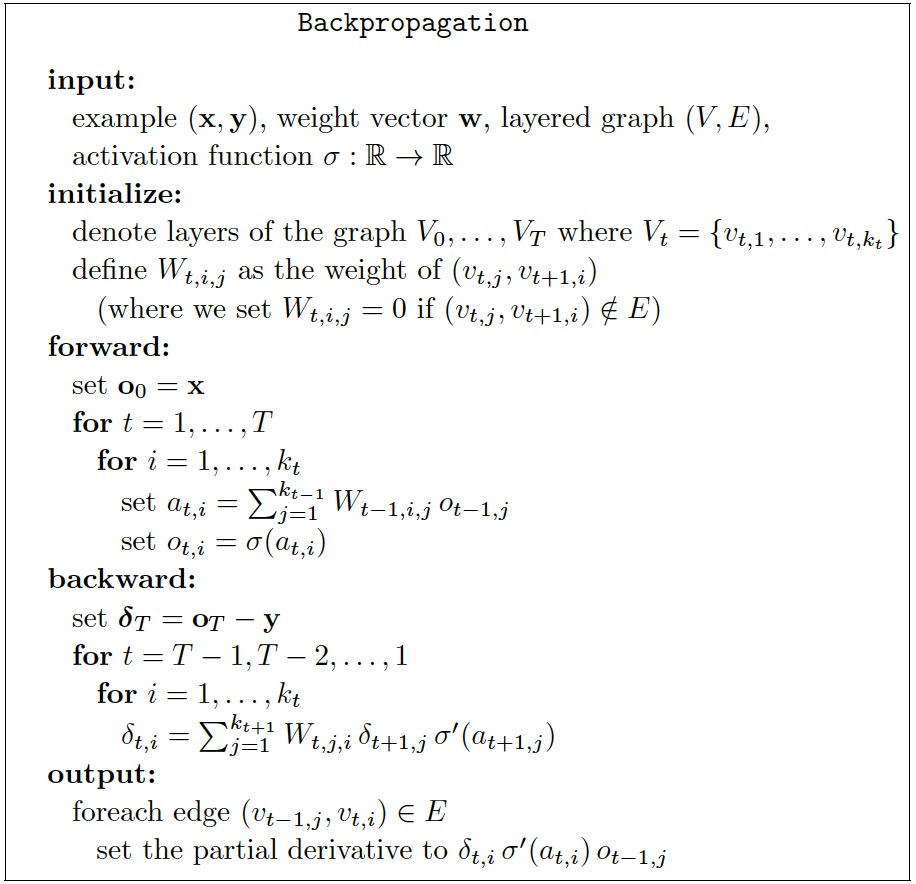

In [28]:
from IPython.display import Image
Image(filename='src/backpropagation.png') 

In [29]:
def back_propagation(y_enc, X,w_matrix, w0_matrix, a_matrix, z_matrix):
    # Number of layers
    T = len(w_matrix)

    # Initialize Matrix
    sigma = {}
    d_sigma = {}
    grad_w = {}
    grad_w0 = {}
    
    # Find Sigma for each layer
    sigma[T-1] = a_matrix[T-1] - y_enc
    
    for i in range(T-1,0,-1):
        d_sigma[i-1] = a_matrix[i-1]*(1.0 - a_matrix[i-1])
        sigma[i-1] = np.dot(sigma[i],w_matrix[i].T)*d_sigma[i-1]  
        
    # Find Gradient
    
    for i in range(T,1,-1):
        grad_w[i-1] = np.dot(a_matrix[i-2].T,sigma[i-1])
        grad_w0[i-1] = np.sum(sigma[i-1],axis=0)

    grad_w[0] = np.dot(X.T, sigma[0])
    grad_w0[0] = np.sum(sigma[0],axis = 0)
    
    return grad_w, grad_w0

### 3.11 Update weight and bias with regularization

Once the gradient is calculated for all the weight and bias, the next step is updating the current weight and bias. A weight decay method is used to reduce the overfitting risk. [4]

* Subtract $\lambda w$ every time update the w
* This will give the weight a tendency to zero, in order to prevent overfitting.
* $\lambda$ call weight loss factor
* No need to regularize on bias term


The function used to update the weight and bias are

$$w = w - \eta*(\nabla J_{w} + \lambda w)$$

$$w_0 = w_0 - \eta * \nabla J_{w_0}$$

where, $\eta$ is the learning rate.

In [30]:
def update_w_n_w0(grad_w,grad_w0,w_matrix, w0_matrix, para_eta, para_lambda):
    T = len(w_matrix)
    
    for i in range(0,T):
        w_matrix[i] =  w_matrix[i] - para_eta * \
        (grad_w[i] + para_lambda*w_matrix[i])
        w0_matrix[i] = w0_matrix[i] - para_eta * \
        (grad_w0[i])
        
    return w_matrix, w0_matrix

### 3.12 Calculate Accuracy

Following method is used to calculate the accuracy by comparing the prediction and label.

In [31]:
def calc_accuracy(y,pred_y):
    accuracy = (np.sum(y == pred_y))*1.0/(y.shape[0])
    
    return accuracy

### 3.13 Batch Training

This feature was not planned. However, after running into an extremely low efficiency result. The network took too long time to converge. Batch training is implemented. Current training method will train based on a random batch of the entire training sample and update the weight and bias according. This method significantly reduce the training time.

## 4. Neural Network Implementation

The aim of neural network implementation is to create a method being able to return a network with input of following:

* Training data X
* Node of each hidden layer
* Number of iteration (epochs)
* Learning rate
* L2 Regularization

-----

The number of hidden layer is 1 for this project. It can be further expanded if time allow to support multiple hidden layer.

In [32]:
from sklearn.utils import shuffle

class NNClassifier():
    
    # Initialize the Nueral Network
    def __init__(self, hidden, epochs, para_eta, para_lambda, batch_size):
        self.epochs = epochs
        self.para_eta = para_eta
        self.para_lambda = para_lambda
        self.hidden = hidden
        self.w_matrix = {}
        self.w0_matrix = {}
        self.train_acc = []
        self.valid_acc = []
        self.train_err = []
        self.valid_err = []
        self.batch_size = batch_size
        
    def pred(self,X):
        z_matrix, a_matrix = forward_feed(X,self.w_matrix,self.w0_matrix)
        return np.argmax(a_matrix[len(z_matrix)-1],axis=1) 
    
    def train(self,train_X,train_y,valid_X,valid_y):
        train_X, train_y = shuffle(train_X, train_y)
        
        
        # Determine no of input and output layer
        self.no_feature = train_X.shape[1]
        self.no_output = np.unique(train_y).shape[0]
        self.no_train_sample = train_X.shape[0]
        
        # Define the network's structure
        dim = gen_network_dim(self.no_feature, self.no_output, self.hidden)
        
        # Initialize Weight and Bias
        self.w_matrix,self.w0_matrix = init_w_and_w0_matrix(dim)
        
        # One-hot encoding of y
        train_y_encoded = onehotencoding(train_y)
        valid_y_encoded = onehotencoding(valid_y)
        
        # Re-initialize accuracy lists
        self.train_acc = []
        self.valid_acc = []
    
        # Loop over epochs
        for i in range(0,self.epochs):
            
            # Randomize the input
            train_X, train_y, train_y_encoded = shuffle(train_X, train_y, train_y_encoded)
            
            # Batch Training
            index = np.arange(0, self.no_train_sample - self.batch_size + 1, self.batch_size)

            for j in index:
                batch = np.arange(j,j+self.batch_size)
                
                X = train_X[batch]
                y = train_y[batch]
                y_enc = train_y_encoded[batch]
                
                
                # Forward Feed
                z_matrix, a_matrix = forward_feed(X,self.w_matrix,self.w0_matrix)

                # Back-propagation
                grad_w, grad_w0 = back_propagation(y_enc, X, self.w_matrix, \
                                                   self.w0_matrix, a_matrix, z_matrix, )

                # Update w and w0
                self.w_matrix, self.w0_matrix = update_w_n_w0(grad_w,grad_w0,self.w_matrix, \
                                                              self.w0_matrix, self.para_eta, \
                                                              self.para_lambda)

            # Make a prediction
            pred_y_train = self.pred(train_X)
            pred_y_valid = self.pred(valid_X)
                
            # Calculate Accuracy for training set and validation set
            self.train_acc.append(calc_accuracy(train_y,pred_y_train))
            self.valid_acc.append(calc_accuracy(valid_y,pred_y_valid))

            # Calculate Error
            self.train_err.append(calc_training_error(pred_y_train,train_y))
            self.valid_err.append(calc_training_error(pred_y_valid,valid_y))
            
            print({i: ["Train Accuracy = ", self.train_acc[i], \
                       "Valid Accuracy = ", self.valid_acc[i]]})
            
        return self
    
    def plot_training(self):
        plt.subplot(1,2,1)
        iterations = np.arange(1,self.epochs+1)
        plt.plot(iterations,self.train_acc, label='Training')
        plt.plot(iterations,self.valid_acc, label='Validation')
        plt.legend(loc='lower right')
        plt.title("Accuracy vs. Epochs")
        
        plt.subplot(1,2,2)
        iterations = np.arange(1,self.epochs+1)
        plt.plot(iterations,self.train_err, label='Training')
        plt.plot(iterations,self.valid_err, label='Validation')
        plt.legend(loc='upper right')
        plt.title("Error vs. Epochs")
        
        plt.show()
    


## 5. Result:

Once the implementation is completed. A few models are trained to explore the effects of network structure on training. Total 11 models are trained, as listed below:

1. Single hidden layer models
    * 25 nodes
    * 50 nodes
    * 100 nodes
    * 200 nodes
    
2. Two hidden layer models:
    * 200 nodes for 1st hidden layer and 100 nodes for 2nd hidden layer
    * 200 nodes for 1st hidden layer and 50 nodes for 2nd hidden layer
    * 200 nodes for 1st hidden layer and 25 nodes for 2nd hidden layer
    * 100 nodes for 1st hidden layer and 200 nodes for 2nd hidden layer
    
3. Three hidden layer models:
    * 1st layer: 200 ; 2nd layer: 100; 3rd layer: 100
    * 1st layer: 200 ; 2nd layer: 100; 3rd layer: 50
    * 1st layer: 200 ; 2nd layer: 100; 3rd layer: 25
    * 1st layer: 50 ; 2nd layer: 25; 3rd layer: 15

The training is fixed with 50 epochs and $\eta = 0.0005$, $\lambda = 0.01$

## Appendix. Trained models:



## 5.1 Single Hidden layer with different nodes

{0: ['Train Accuracy = ', 0.4500625, 'Valid Accuracy = ', 0.45175]}
{1: ['Train Accuracy = ', 0.5994583333333333, 'Valid Accuracy = ', 0.5948333333333333]}
{2: ['Train Accuracy = ', 0.6566041666666667, 'Valid Accuracy = ', 0.65325]}
{3: ['Train Accuracy = ', 0.7087083333333334, 'Valid Accuracy = ', 0.7073333333333334]}
{4: ['Train Accuracy = ', 0.7343958333333334, 'Valid Accuracy = ', 0.7363333333333333]}
{5: ['Train Accuracy = ', 0.74575, 'Valid Accuracy = ', 0.7456666666666667]}
{6: ['Train Accuracy = ', 0.761, 'Valid Accuracy = ', 0.7629166666666667]}
{7: ['Train Accuracy = ', 0.7722708333333334, 'Valid Accuracy = ', 0.7754166666666666]}
{8: ['Train Accuracy = ', 0.7981041666666666, 'Valid Accuracy = ', 0.7968333333333333]}
{9: ['Train Accuracy = ', 0.802, 'Valid Accuracy = ', 0.7988333333333333]}
{10: ['Train Accuracy = ', 0.8138125, 'Valid Accuracy = ', 0.8155833333333333]}
{11: ['Train Accuracy = ', 0.8174583333333333, 'Valid Accuracy = ', 0.8158333333333333]}
{12: ['Train Accura

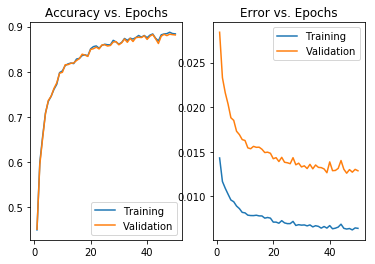

In [32]:
hidden = [25]

nn1 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn1.train(train_X,train_y,valid_X,valid_y)
nn1.plot_training()

In [33]:
pred_y_test = nn1.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.8923


{0: ['Train Accuracy = ', 0.5825416666666666, 'Valid Accuracy = ', 0.5769166666666666]}
{1: ['Train Accuracy = ', 0.6886875, 'Valid Accuracy = ', 0.6835833333333333]}
{2: ['Train Accuracy = ', 0.7508958333333333, 'Valid Accuracy = ', 0.7415833333333334]}
{3: ['Train Accuracy = ', 0.7802708333333334, 'Valid Accuracy = ', 0.7755]}
{4: ['Train Accuracy = ', 0.7920625, 'Valid Accuracy = ', 0.7903333333333333]}
{5: ['Train Accuracy = ', 0.8104375, 'Valid Accuracy = ', 0.8096666666666666]}
{6: ['Train Accuracy = ', 0.818125, 'Valid Accuracy = ', 0.8138333333333333]}
{7: ['Train Accuracy = ', 0.833125, 'Valid Accuracy = ', 0.8284166666666667]}
{8: ['Train Accuracy = ', 0.8418541666666667, 'Valid Accuracy = ', 0.8378333333333333]}
{9: ['Train Accuracy = ', 0.8453125, 'Valid Accuracy = ', 0.8394166666666667]}
{10: ['Train Accuracy = ', 0.853, 'Valid Accuracy = ', 0.8474166666666667]}
{11: ['Train Accuracy = ', 0.85325, 'Valid Accuracy = ', 0.8495]}
{12: ['Train Accuracy = ', 0.8583541666666666,

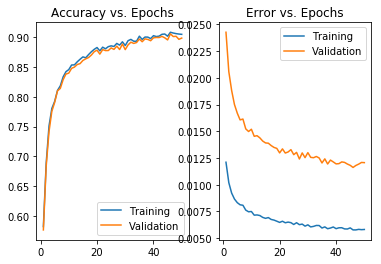

In [34]:
hidden = [50]

nn2 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn2.train(train_X,train_y,valid_X,valid_y)
nn2.plot_training()

In [35]:
pred_y_test = nn2.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9034


{0: ['Train Accuracy = ', 0.66975, 'Valid Accuracy = ', 0.6575833333333333]}
{1: ['Train Accuracy = ', 0.7598958333333333, 'Valid Accuracy = ', 0.75475]}
{2: ['Train Accuracy = ', 0.795875, 'Valid Accuracy = ', 0.7930833333333334]}
{3: ['Train Accuracy = ', 0.8202291666666667, 'Valid Accuracy = ', 0.8160833333333334]}
{4: ['Train Accuracy = ', 0.8343541666666666, 'Valid Accuracy = ', 0.82775]}
{5: ['Train Accuracy = ', 0.8501041666666667, 'Valid Accuracy = ', 0.84475]}
{6: ['Train Accuracy = ', 0.8559375, 'Valid Accuracy = ', 0.8483333333333334]}
{7: ['Train Accuracy = ', 0.86275, 'Valid Accuracy = ', 0.8590833333333333]}
{8: ['Train Accuracy = ', 0.8662291666666667, 'Valid Accuracy = ', 0.8616666666666667]}
{9: ['Train Accuracy = ', 0.8721041666666667, 'Valid Accuracy = ', 0.8680833333333333]}
{10: ['Train Accuracy = ', 0.875375, 'Valid Accuracy = ', 0.8716666666666667]}
{11: ['Train Accuracy = ', 0.8801458333333333, 'Valid Accuracy = ', 0.8795]}
{12: ['Train Accuracy = ', 0.883375, '

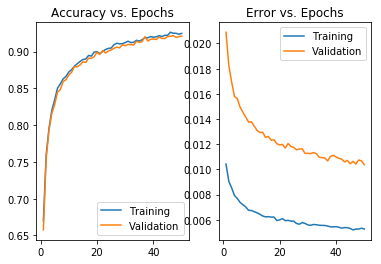

In [36]:
hidden = [100]

nn3 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn3.train(train_X,train_y,valid_X,valid_y)
nn3.plot_training()

In [37]:
pred_y_test = nn3.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.924


{0: ['Train Accuracy = ', 0.704875, 'Valid Accuracy = ', 0.70475]}
{1: ['Train Accuracy = ', 0.7851875, 'Valid Accuracy = ', 0.7766666666666666]}
{2: ['Train Accuracy = ', 0.8148333333333333, 'Valid Accuracy = ', 0.8176666666666667]}
{3: ['Train Accuracy = ', 0.8341041666666666, 'Valid Accuracy = ', 0.8283333333333334]}
{4: ['Train Accuracy = ', 0.8492083333333333, 'Valid Accuracy = ', 0.84625]}
{5: ['Train Accuracy = ', 0.8594375, 'Valid Accuracy = ', 0.86275]}
{6: ['Train Accuracy = ', 0.8718541666666667, 'Valid Accuracy = ', 0.8695833333333334]}
{7: ['Train Accuracy = ', 0.8792708333333333, 'Valid Accuracy = ', 0.8771666666666667]}
{8: ['Train Accuracy = ', 0.8832291666666666, 'Valid Accuracy = ', 0.88]}
{9: ['Train Accuracy = ', 0.888375, 'Valid Accuracy = ', 0.8848333333333334]}
{10: ['Train Accuracy = ', 0.890625, 'Valid Accuracy = ', 0.88975]}
{11: ['Train Accuracy = ', 0.8959583333333333, 'Valid Accuracy = ', 0.8921666666666667]}
{12: ['Train Accuracy = ', 0.8959583333333333, '

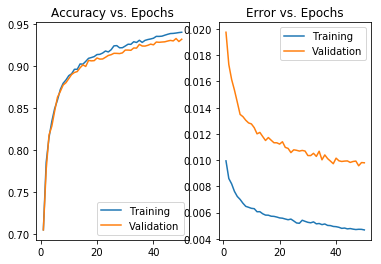

In [38]:
hidden = [200]

nn4 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn4.train(train_X,train_y,valid_X,valid_y)
nn4.plot_training()

In [39]:
pred_y_test = nn4.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9337


---
## 5.2 Two hidden layer with different second hidden layer

{0: ['Train Accuracy = ', 0.6744583333333334, 'Valid Accuracy = ', 0.6700833333333334]}
{1: ['Train Accuracy = ', 0.7644375, 'Valid Accuracy = ', 0.76075]}
{2: ['Train Accuracy = ', 0.8006458333333333, 'Valid Accuracy = ', 0.7953333333333333]}
{3: ['Train Accuracy = ', 0.8262291666666667, 'Valid Accuracy = ', 0.8165]}
{4: ['Train Accuracy = ', 0.8376666666666667, 'Valid Accuracy = ', 0.836]}
{5: ['Train Accuracy = ', 0.8503333333333334, 'Valid Accuracy = ', 0.8495]}
{6: ['Train Accuracy = ', 0.8581666666666666, 'Valid Accuracy = ', 0.85525]}
{7: ['Train Accuracy = ', 0.8659791666666666, 'Valid Accuracy = ', 0.864]}
{8: ['Train Accuracy = ', 0.8710625, 'Valid Accuracy = ', 0.8699166666666667]}
{9: ['Train Accuracy = ', 0.8757708333333334, 'Valid Accuracy = ', 0.8685]}
{10: ['Train Accuracy = ', 0.8825833333333334, 'Valid Accuracy = ', 0.8791666666666667]}
{11: ['Train Accuracy = ', 0.8841041666666667, 'Valid Accuracy = ', 0.8813333333333333]}
{12: ['Train Accuracy = ', 0.887541666666666

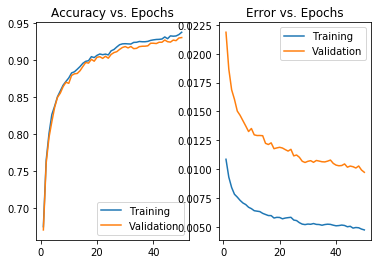

In [40]:
hidden = [200,100]

nn5 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn5.train(train_X,train_y,valid_X,valid_y)
nn5.plot_training()

In [41]:
pred_y_test = nn5.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9332


{0: ['Train Accuracy = ', 0.6220416666666667, 'Valid Accuracy = ', 0.61725]}
{1: ['Train Accuracy = ', 0.7198541666666667, 'Valid Accuracy = ', 0.7215]}
{2: ['Train Accuracy = ', 0.7693125, 'Valid Accuracy = ', 0.7649166666666667]}
{3: ['Train Accuracy = ', 0.8038333333333333, 'Valid Accuracy = ', 0.7978333333333333]}
{4: ['Train Accuracy = ', 0.8242916666666666, 'Valid Accuracy = ', 0.818]}
{5: ['Train Accuracy = ', 0.8385, 'Valid Accuracy = ', 0.8315833333333333]}
{6: ['Train Accuracy = ', 0.8488125, 'Valid Accuracy = ', 0.8463333333333334]}
{7: ['Train Accuracy = ', 0.8580208333333333, 'Valid Accuracy = ', 0.851]}
{8: ['Train Accuracy = ', 0.8633333333333333, 'Valid Accuracy = ', 0.8574166666666667]}
{9: ['Train Accuracy = ', 0.8692083333333334, 'Valid Accuracy = ', 0.863]}
{10: ['Train Accuracy = ', 0.8751041666666667, 'Valid Accuracy = ', 0.8724166666666666]}
{11: ['Train Accuracy = ', 0.8776666666666667, 'Valid Accuracy = ', 0.87325]}
{12: ['Train Accuracy = ', 0.881375, 'Valid A

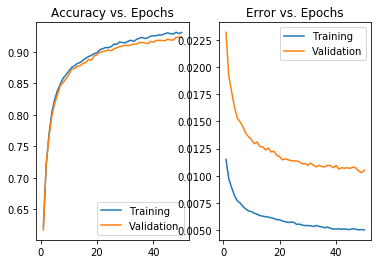

In [42]:
hidden = [200,50]

nn6 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn6.train(train_X,train_y,valid_X,valid_y)
nn6.plot_training()

In [43]:
pred_y_test = nn6.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9222


{0: ['Train Accuracy = ', 0.5093958333333334, 'Valid Accuracy = ', 0.5073333333333333]}
{1: ['Train Accuracy = ', 0.6522916666666667, 'Valid Accuracy = ', 0.6543333333333333]}
{2: ['Train Accuracy = ', 0.7318541666666667, 'Valid Accuracy = ', 0.7331666666666666]}
{3: ['Train Accuracy = ', 0.7761041666666667, 'Valid Accuracy = ', 0.775]}
{4: ['Train Accuracy = ', 0.8010833333333334, 'Valid Accuracy = ', 0.8025]}
{5: ['Train Accuracy = ', 0.8183333333333334, 'Valid Accuracy = ', 0.8231666666666667]}
{6: ['Train Accuracy = ', 0.8360625, 'Valid Accuracy = ', 0.8364166666666667]}
{7: ['Train Accuracy = ', 0.8426666666666667, 'Valid Accuracy = ', 0.8425]}
{8: ['Train Accuracy = ', 0.8519375, 'Valid Accuracy = ', 0.85275]}
{9: ['Train Accuracy = ', 0.861375, 'Valid Accuracy = ', 0.8576666666666667]}
{10: ['Train Accuracy = ', 0.865625, 'Valid Accuracy = ', 0.8636666666666667]}
{11: ['Train Accuracy = ', 0.8703958333333334, 'Valid Accuracy = ', 0.8661666666666666]}
{12: ['Train Accuracy = ', 0

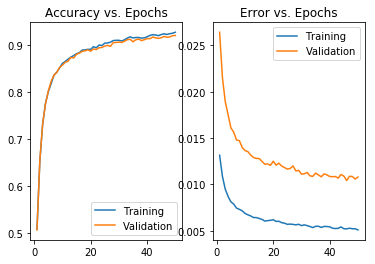

In [44]:
hidden = [200,25]

nn7 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn7.train(train_X,train_y,valid_X,valid_y)
nn7.plot_training()

In [45]:
pred_y_test = nn7.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9199


{0: ['Train Accuracy = ', 0.6907708333333333, 'Valid Accuracy = ', 0.6810833333333334]}
{1: ['Train Accuracy = ', 0.7642291666666666, 'Valid Accuracy = ', 0.7584166666666666]}
{2: ['Train Accuracy = ', 0.8021458333333333, 'Valid Accuracy = ', 0.7925833333333333]}
{3: ['Train Accuracy = ', 0.8213958333333333, 'Valid Accuracy = ', 0.81675]}
{4: ['Train Accuracy = ', 0.8344375, 'Valid Accuracy = ', 0.8335]}
{5: ['Train Accuracy = ', 0.8386666666666667, 'Valid Accuracy = ', 0.837]}
{6: ['Train Accuracy = ', 0.8533125, 'Valid Accuracy = ', 0.8463333333333334]}
{7: ['Train Accuracy = ', 0.8616875, 'Valid Accuracy = ', 0.8563333333333333]}
{8: ['Train Accuracy = ', 0.8691458333333333, 'Valid Accuracy = ', 0.8599166666666667]}
{9: ['Train Accuracy = ', 0.8738958333333333, 'Valid Accuracy = ', 0.8640833333333333]}
{10: ['Train Accuracy = ', 0.8775833333333334, 'Valid Accuracy = ', 0.8665833333333334]}
{11: ['Train Accuracy = ', 0.8804791666666667, 'Valid Accuracy = ', 0.86975]}
{12: ['Train Acc

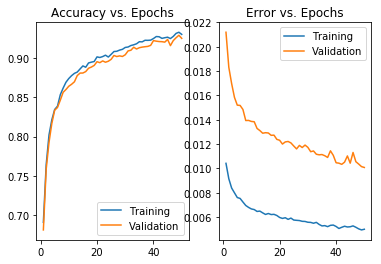

In [46]:
hidden = [100,200]

nn8 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn8.train(train_X,train_y,valid_X,valid_y)
nn8.plot_training()

In [47]:
pred_y_test = nn8.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9264


---
## 5.3 Three hidden layer with different third hidden layer

{0: ['Train Accuracy = ', 0.6325, 'Valid Accuracy = ', 0.6331666666666667]}
{1: ['Train Accuracy = ', 0.7377083333333333, 'Valid Accuracy = ', 0.73925]}
{2: ['Train Accuracy = ', 0.7816458333333334, 'Valid Accuracy = ', 0.7793333333333333]}
{3: ['Train Accuracy = ', 0.8112083333333333, 'Valid Accuracy = ', 0.807]}
{4: ['Train Accuracy = ', 0.8307291666666666, 'Valid Accuracy = ', 0.823]}
{5: ['Train Accuracy = ', 0.8404166666666667, 'Valid Accuracy = ', 0.8355]}
{6: ['Train Accuracy = ', 0.849875, 'Valid Accuracy = ', 0.84625]}
{7: ['Train Accuracy = ', 0.85725, 'Valid Accuracy = ', 0.8535833333333334]}
{8: ['Train Accuracy = ', 0.8655208333333333, 'Valid Accuracy = ', 0.8615]}
{9: ['Train Accuracy = ', 0.8714791666666667, 'Valid Accuracy = ', 0.866]}
{10: ['Train Accuracy = ', 0.8777083333333333, 'Valid Accuracy = ', 0.8733333333333333]}
{11: ['Train Accuracy = ', 0.8825208333333333, 'Valid Accuracy = ', 0.879]}
{12: ['Train Accuracy = ', 0.8833333333333333, 'Valid Accuracy = ', 0.880

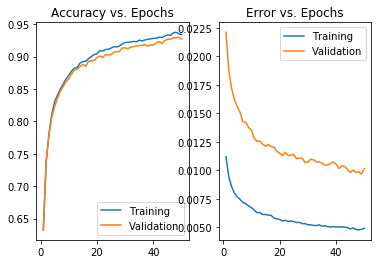

In [48]:
hidden = [200,100,100]

nn9 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn9.train(train_X,train_y,valid_X,valid_y)
nn9.plot_training()

In [49]:
pred_y_test = nn9.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9281


{0: ['Train Accuracy = ', 0.6305416666666667, 'Valid Accuracy = ', 0.6223333333333333]}
{1: ['Train Accuracy = ', 0.7416041666666666, 'Valid Accuracy = ', 0.7389166666666667]}
{2: ['Train Accuracy = ', 0.7911458333333333, 'Valid Accuracy = ', 0.7845]}
{3: ['Train Accuracy = ', 0.8191041666666666, 'Valid Accuracy = ', 0.81575]}
{4: ['Train Accuracy = ', 0.8352291666666667, 'Valid Accuracy = ', 0.8323333333333334]}
{5: ['Train Accuracy = ', 0.8466041666666667, 'Valid Accuracy = ', 0.8419166666666666]}
{6: ['Train Accuracy = ', 0.8587291666666667, 'Valid Accuracy = ', 0.85325]}
{7: ['Train Accuracy = ', 0.8635208333333333, 'Valid Accuracy = ', 0.8598333333333333]}
{8: ['Train Accuracy = ', 0.8720208333333334, 'Valid Accuracy = ', 0.8664166666666666]}
{9: ['Train Accuracy = ', 0.8758125, 'Valid Accuracy = ', 0.868]}
{10: ['Train Accuracy = ', 0.8813541666666667, 'Valid Accuracy = ', 0.8736666666666667]}
{11: ['Train Accuracy = ', 0.8844375, 'Valid Accuracy = ', 0.8766666666666667]}
{12: ['

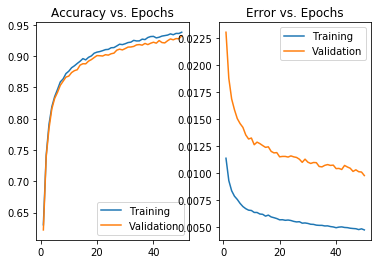

In [51]:
#### hidden = [200,100,50]

nn10 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn10.train(train_X,train_y,valid_X,valid_y)
nn10.plot_training()

In [52]:
pred_y_test = nn10.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9344


{0: ['Train Accuracy = ', 0.5456875, 'Valid Accuracy = ', 0.5460833333333334]}
{1: ['Train Accuracy = ', 0.6680833333333334, 'Valid Accuracy = ', 0.6691666666666667]}
{2: ['Train Accuracy = ', 0.7367291666666667, 'Valid Accuracy = ', 0.73425]}
{3: ['Train Accuracy = ', 0.7805208333333333, 'Valid Accuracy = ', 0.7803333333333333]}
{4: ['Train Accuracy = ', 0.8065208333333334, 'Valid Accuracy = ', 0.80475]}
{5: ['Train Accuracy = ', 0.8225, 'Valid Accuracy = ', 0.8188333333333333]}
{6: ['Train Accuracy = ', 0.8353541666666666, 'Valid Accuracy = ', 0.8331666666666667]}
{7: ['Train Accuracy = ', 0.8458333333333333, 'Valid Accuracy = ', 0.8439166666666666]}
{8: ['Train Accuracy = ', 0.8559375, 'Valid Accuracy = ', 0.85425]}
{9: ['Train Accuracy = ', 0.8640416666666667, 'Valid Accuracy = ', 0.8593333333333333]}
{10: ['Train Accuracy = ', 0.8654375, 'Valid Accuracy = ', 0.862]}
{11: ['Train Accuracy = ', 0.869, 'Valid Accuracy = ', 0.87025]}
{12: ['Train Accuracy = ', 0.875625, 'Valid Accurac

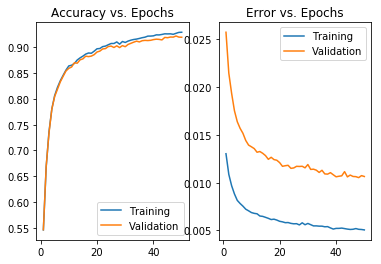

In [53]:
hidden = [200,100,25]

nn11 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn11.train(train_X,train_y,valid_X,valid_y)
nn11.plot_training()

In [54]:
pred_y_test = nn11.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9242


{0: ['Train Accuracy = ', 0.30622916666666666, 'Valid Accuracy = ', 0.31133333333333335]}
{1: ['Train Accuracy = ', 0.45877083333333335, 'Valid Accuracy = ', 0.457]}
{2: ['Train Accuracy = ', 0.5687916666666667, 'Valid Accuracy = ', 0.5708333333333333]}
{3: ['Train Accuracy = ', 0.6236458333333333, 'Valid Accuracy = ', 0.62375]}
{4: ['Train Accuracy = ', 0.6617083333333333, 'Valid Accuracy = ', 0.6601666666666667]}
{5: ['Train Accuracy = ', 0.6847708333333333, 'Valid Accuracy = ', 0.6769166666666667]}
{6: ['Train Accuracy = ', 0.7075208333333334, 'Valid Accuracy = ', 0.7026666666666667]}
{7: ['Train Accuracy = ', 0.7304583333333333, 'Valid Accuracy = ', 0.732]}
{8: ['Train Accuracy = ', 0.7428541666666667, 'Valid Accuracy = ', 0.7370833333333333]}
{9: ['Train Accuracy = ', 0.7623333333333333, 'Valid Accuracy = ', 0.757]}
{10: ['Train Accuracy = ', 0.7677916666666667, 'Valid Accuracy = ', 0.7643333333333333]}
{11: ['Train Accuracy = ', 0.7814166666666666, 'Valid Accuracy = ', 0.77825]}


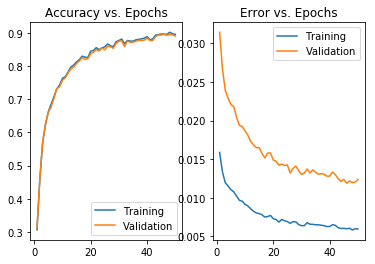

In [55]:
hidden = [50,25,15]

nn12 = NNClassifier(hidden, 50, 0.0005, 0.01,100)
nn12.train(train_X,train_y,valid_X,valid_y)
nn12.plot_training()

In [56]:
pred_y_test = nn12.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.8906


Text(0.5,1,'Accuracy vs. Epochs')

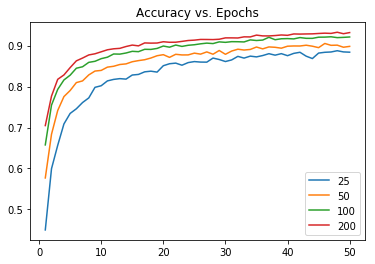

In [57]:
plt.subplot(1,1,1)
iterations = np.arange(1,50+1)
plt.plot(iterations,nn1.train_acc, label='25')
plt.plot(iterations,nn2.valid_acc, label='50')
plt.plot(iterations,nn3.valid_acc, label='100')
plt.plot(iterations,nn4.valid_acc, label='200')
plt.legend(loc='lower right')
plt.title("Accuracy vs. Epochs")

{0: ['Train Accuracy = ', 0.598625, 'Valid Accuracy = ', 0.59825]}
{1: ['Train Accuracy = ', 0.7049791666666667, 'Valid Accuracy = ', 0.7030833333333333]}
{2: ['Train Accuracy = ', 0.7546458333333333, 'Valid Accuracy = ', 0.7515833333333334]}
{3: ['Train Accuracy = ', 0.7796041666666667, 'Valid Accuracy = ', 0.7765]}
{4: ['Train Accuracy = ', 0.7959375, 'Valid Accuracy = ', 0.7906666666666666]}
{5: ['Train Accuracy = ', 0.8175208333333334, 'Valid Accuracy = ', 0.81525]}
{6: ['Train Accuracy = ', 0.8165833333333333, 'Valid Accuracy = ', 0.8141666666666667]}
{7: ['Train Accuracy = ', 0.8254166666666667, 'Valid Accuracy = ', 0.8235]}
{8: ['Train Accuracy = ', 0.83875, 'Valid Accuracy = ', 0.8350833333333333]}
{9: ['Train Accuracy = ', 0.8401666666666666, 'Valid Accuracy = ', 0.8411666666666666]}
{10: ['Train Accuracy = ', 0.8460208333333333, 'Valid Accuracy = ', 0.847]}
{11: ['Train Accuracy = ', 0.8498333333333333, 'Valid Accuracy = ', 0.84475]}
{12: ['Train Accuracy = ', 0.8621666666666

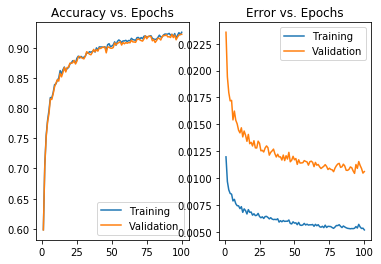

In [58]:
hidden = [50]

nn13 = NNClassifier(hidden, 100, 0.0005, 0.01,100)
nn13.train(train_X,train_y,valid_X,valid_y)
nn13.plot_training()

In [59]:
pred_y_test = nn13.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9245


{0: ['Train Accuracy = ', 0.5821458333333334, 'Valid Accuracy = ', 0.5865]}
{1: ['Train Accuracy = ', 0.7006875, 'Valid Accuracy = ', 0.6980833333333333]}
{2: ['Train Accuracy = ', 0.7481666666666666, 'Valid Accuracy = ', 0.7515]}
{3: ['Train Accuracy = ', 0.7766041666666667, 'Valid Accuracy = ', 0.776]}
{4: ['Train Accuracy = ', 0.788625, 'Valid Accuracy = ', 0.7853333333333333]}
{5: ['Train Accuracy = ', 0.8025208333333333, 'Valid Accuracy = ', 0.80125]}
{6: ['Train Accuracy = ', 0.820875, 'Valid Accuracy = ', 0.8184166666666667]}
{7: ['Train Accuracy = ', 0.8253958333333333, 'Valid Accuracy = ', 0.828]}
{8: ['Train Accuracy = ', 0.8347083333333334, 'Valid Accuracy = ', 0.836]}
{9: ['Train Accuracy = ', 0.8432083333333333, 'Valid Accuracy = ', 0.84425]}
{10: ['Train Accuracy = ', 0.8490625, 'Valid Accuracy = ', 0.8460833333333333]}
{11: ['Train Accuracy = ', 0.8471875, 'Valid Accuracy = ', 0.8471666666666666]}
{12: ['Train Accuracy = ', 0.8512083333333333, 'Valid Accuracy = ', 0.8501

{100: ['Train Accuracy = ', 0.9260833333333334, 'Valid Accuracy = ', 0.921]}
{101: ['Train Accuracy = ', 0.9291875, 'Valid Accuracy = ', 0.9233333333333333]}
{102: ['Train Accuracy = ', 0.9247291666666667, 'Valid Accuracy = ', 0.9235]}
{103: ['Train Accuracy = ', 0.9285, 'Valid Accuracy = ', 0.9256666666666666]}
{104: ['Train Accuracy = ', 0.9236041666666667, 'Valid Accuracy = ', 0.92125]}
{105: ['Train Accuracy = ', 0.9217083333333334, 'Valid Accuracy = ', 0.91775]}
{106: ['Train Accuracy = ', 0.9257083333333334, 'Valid Accuracy = ', 0.9214166666666667]}
{107: ['Train Accuracy = ', 0.9244375, 'Valid Accuracy = ', 0.9199166666666667]}
{108: ['Train Accuracy = ', 0.9251041666666666, 'Valid Accuracy = ', 0.9220833333333334]}
{109: ['Train Accuracy = ', 0.9269791666666667, 'Valid Accuracy = ', 0.9228333333333333]}
{110: ['Train Accuracy = ', 0.9286041666666667, 'Valid Accuracy = ', 0.922]}
{111: ['Train Accuracy = ', 0.928875, 'Valid Accuracy = ', 0.9228333333333333]}
{112: ['Train Accura

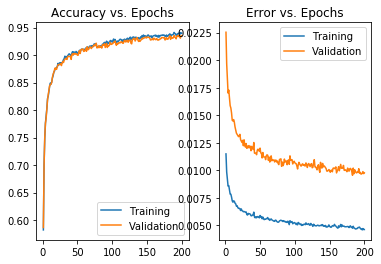

In [60]:
hidden = [50]

nn14 = NNClassifier(hidden, 200, 0.0005, 0.01,100)
nn14.train(train_X,train_y,valid_X,valid_y)
nn14.plot_training()

In [61]:
pred_y_test = nn14.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9381


{0: ['Train Accuracy = ', 0.5970833333333333, 'Valid Accuracy = ', 0.6006666666666667]}
{1: ['Train Accuracy = ', 0.6295833333333334, 'Valid Accuracy = ', 0.629]}
{2: ['Train Accuracy = ', 0.686375, 'Valid Accuracy = ', 0.68575]}
{3: ['Train Accuracy = ', 0.6411875, 'Valid Accuracy = ', 0.6396666666666667]}
{4: ['Train Accuracy = ', 0.7120416666666667, 'Valid Accuracy = ', 0.7148333333333333]}
{5: ['Train Accuracy = ', 0.7008333333333333, 'Valid Accuracy = ', 0.703]}
{6: ['Train Accuracy = ', 0.6860625, 'Valid Accuracy = ', 0.6863333333333334]}
{7: ['Train Accuracy = ', 0.73925, 'Valid Accuracy = ', 0.7426666666666667]}
{8: ['Train Accuracy = ', 0.7358541666666667, 'Valid Accuracy = ', 0.7433333333333333]}
{9: ['Train Accuracy = ', 0.723625, 'Valid Accuracy = ', 0.7268333333333333]}
{10: ['Train Accuracy = ', 0.6596458333333334, 'Valid Accuracy = ', 0.6625833333333333]}
{11: ['Train Accuracy = ', 0.6588333333333334, 'Valid Accuracy = ', 0.66175]}
{12: ['Train Accuracy = ', 0.689875, 'V

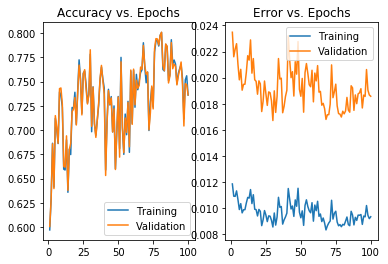

In [62]:
hidden = [50]

nn15 = NNClassifier(hidden, 100, 0.005, 0.01,100)
nn15.train(train_X,train_y,valid_X,valid_y)
nn15.plot_training()

In [63]:
pred_y_test = nn15.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.7416


{0: ['Train Accuracy = ', 0.09808333333333333, 'Valid Accuracy = ', 0.10016666666666667]}
{1: ['Train Accuracy = ', 0.15725, 'Valid Accuracy = ', 0.15458333333333332]}
{2: ['Train Accuracy = ', 0.15079166666666666, 'Valid Accuracy = ', 0.15183333333333332]}
{3: ['Train Accuracy = ', 0.09804166666666667, 'Valid Accuracy = ', 0.09683333333333333]}
{4: ['Train Accuracy = ', 0.09808333333333333, 'Valid Accuracy = ', 0.10016666666666667]}
{5: ['Train Accuracy = ', 0.09927083333333334, 'Valid Accuracy = ', 0.0965]}
{6: ['Train Accuracy = ', 0.0898125, 'Valid Accuracy = ', 0.0925]}
{7: ['Train Accuracy = ', 0.09760416666666667, 'Valid Accuracy = ', 0.09766666666666667]}
{8: ['Train Accuracy = ', 0.09752083333333333, 'Valid Accuracy = ', 0.09766666666666667]}
{9: ['Train Accuracy = ', 0.09925, 'Valid Accuracy = ', 0.0995]}
{10: ['Train Accuracy = ', 0.099625, 'Valid Accuracy = ', 0.09683333333333333]}
{11: ['Train Accuracy = ', 0.0985625, 'Valid Accuracy = ', 0.09891666666666667]}
{12: ['Train

{97: ['Train Accuracy = ', 0.0985625, 'Valid Accuracy = ', 0.09891666666666667]}
{98: ['Train Accuracy = ', 0.09925, 'Valid Accuracy = ', 0.0995]}
{99: ['Train Accuracy = ', 0.09925, 'Valid Accuracy = ', 0.0995]}


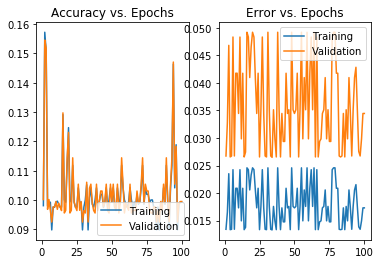

In [64]:
hidden = [50]

nn16 = NNClassifier(hidden, 100, 0.05, 0.01,100)
nn16.train(train_X,train_y,valid_X,valid_y)
nn16.plot_training()

In [65]:
pred_y_test = nn16.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.1032


{0: ['Train Accuracy = ', 0.09760416666666667, 'Valid Accuracy = ', 0.09641666666666666]}
{1: ['Train Accuracy = ', 0.09760416666666667, 'Valid Accuracy = ', 0.09641666666666666]}
{2: ['Train Accuracy = ', 0.09925, 'Valid Accuracy = ', 0.0995]}
{3: ['Train Accuracy = ', 0.09760416666666667, 'Valid Accuracy = ', 0.09641666666666666]}
{4: ['Train Accuracy = ', 0.11185416666666667, 'Valid Accuracy = ', 0.11441666666666667]}
{5: ['Train Accuracy = ', 0.09760416666666667, 'Valid Accuracy = ', 0.09641666666666666]}
{6: ['Train Accuracy = ', 0.09925, 'Valid Accuracy = ', 0.0995]}
{7: ['Train Accuracy = ', 0.10416666666666667, 'Valid Accuracy = ', 0.10541666666666667]}
{8: ['Train Accuracy = ', 0.10416666666666667, 'Valid Accuracy = ', 0.10541666666666667]}
{9: ['Train Accuracy = ', 0.10195833333333333, 'Valid Accuracy = ', 0.10308333333333333]}
{10: ['Train Accuracy = ', 0.10195833333333333, 'Valid Accuracy = ', 0.10308333333333333]}
{11: ['Train Accuracy = ', 0.10004166666666667, 'Valid Accu

{98: ['Train Accuracy = ', 0.09747916666666667, 'Valid Accuracy = ', 0.09766666666666667]}
{99: ['Train Accuracy = ', 0.0898125, 'Valid Accuracy = ', 0.0925]}


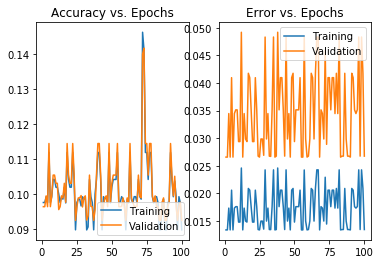

In [66]:
hidden = [50]

nn17 = NNClassifier(hidden, 100, 0.2, 0.01,100)
nn17.train(train_X,train_y,valid_X,valid_y)
nn17.plot_training()

In [67]:
pred_y_test = nn17.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.0892


{0: ['Train Accuracy = ', 0.5657083333333334, 'Valid Accuracy = ', 0.5605]}
{1: ['Train Accuracy = ', 0.6984375, 'Valid Accuracy = ', 0.6924166666666667]}
{2: ['Train Accuracy = ', 0.7629583333333333, 'Valid Accuracy = ', 0.7570833333333333]}
{3: ['Train Accuracy = ', 0.7918333333333333, 'Valid Accuracy = ', 0.7869166666666667]}
{4: ['Train Accuracy = ', 0.8129791666666667, 'Valid Accuracy = ', 0.8095833333333333]}
{5: ['Train Accuracy = ', 0.8306666666666667, 'Valid Accuracy = ', 0.8254166666666667]}
{6: ['Train Accuracy = ', 0.84325, 'Valid Accuracy = ', 0.8416666666666667]}
{7: ['Train Accuracy = ', 0.85225, 'Valid Accuracy = ', 0.8508333333333333]}
{8: ['Train Accuracy = ', 0.8584583333333333, 'Valid Accuracy = ', 0.8559166666666667]}
{9: ['Train Accuracy = ', 0.86325, 'Valid Accuracy = ', 0.8623333333333333]}
{10: ['Train Accuracy = ', 0.8711041666666667, 'Valid Accuracy = ', 0.8660833333333333]}
{11: ['Train Accuracy = ', 0.8753958333333334, 'Valid Accuracy = ', 0.870583333333333

{100: ['Train Accuracy = ', 0.9483541666666667, 'Valid Accuracy = ', 0.9384166666666667]}
{101: ['Train Accuracy = ', 0.9472291666666667, 'Valid Accuracy = ', 0.9396666666666667]}
{102: ['Train Accuracy = ', 0.9507291666666666, 'Valid Accuracy = ', 0.9410833333333334]}
{103: ['Train Accuracy = ', 0.9508958333333334, 'Valid Accuracy = ', 0.9415]}
{104: ['Train Accuracy = ', 0.9498958333333334, 'Valid Accuracy = ', 0.9424166666666667]}
{105: ['Train Accuracy = ', 0.9510833333333333, 'Valid Accuracy = ', 0.9419166666666666]}
{106: ['Train Accuracy = ', 0.9513125, 'Valid Accuracy = ', 0.94225]}
{107: ['Train Accuracy = ', 0.9524375, 'Valid Accuracy = ', 0.9421666666666667]}
{108: ['Train Accuracy = ', 0.9533541666666666, 'Valid Accuracy = ', 0.9446666666666667]}
{109: ['Train Accuracy = ', 0.9539583333333334, 'Valid Accuracy = ', 0.9435833333333333]}
{110: ['Train Accuracy = ', 0.9517083333333334, 'Valid Accuracy = ', 0.9436666666666667]}
{111: ['Train Accuracy = ', 0.953375, 'Valid Accura

{199: ['Train Accuracy = ', 0.9644375, 'Valid Accuracy = ', 0.9521666666666667]}


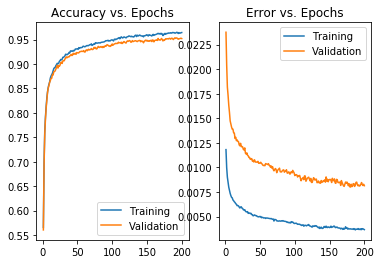

In [68]:
hidden = [200,50]

nn18 = NNClassifier(hidden, 200, 0.0005, 0.01,100)
nn18.train(train_X,train_y,valid_X,valid_y)
nn18.plot_training()

In [69]:
pred_y_test = nn18.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9563


{0: ['Train Accuracy = ', 0.6913541666666667, 'Valid Accuracy = ', 0.6869166666666666]}
{1: ['Train Accuracy = ', 0.765875, 'Valid Accuracy = ', 0.7671666666666667]}
{2: ['Train Accuracy = ', 0.8035416666666667, 'Valid Accuracy = ', 0.8091666666666667]}
{3: ['Train Accuracy = ', 0.8309375, 'Valid Accuracy = ', 0.8245833333333333]}
{4: ['Train Accuracy = ', 0.8443125, 'Valid Accuracy = ', 0.8434166666666667]}
{5: ['Train Accuracy = ', 0.854125, 'Valid Accuracy = ', 0.849]}
{6: ['Train Accuracy = ', 0.865, 'Valid Accuracy = ', 0.86225]}
{7: ['Train Accuracy = ', 0.8671458333333333, 'Valid Accuracy = ', 0.8646666666666667]}
{8: ['Train Accuracy = ', 0.8781041666666667, 'Valid Accuracy = ', 0.8751666666666666]}
{9: ['Train Accuracy = ', 0.8813958333333334, 'Valid Accuracy = ', 0.876]}
{10: ['Train Accuracy = ', 0.8852916666666667, 'Valid Accuracy = ', 0.8813333333333333]}
{11: ['Train Accuracy = ', 0.8888958333333333, 'Valid Accuracy = ', 0.885]}
{12: ['Train Accuracy = ', 0.89347916666666

{101: ['Train Accuracy = ', 0.954875, 'Valid Accuracy = ', 0.9425833333333333]}
{102: ['Train Accuracy = ', 0.9546875, 'Valid Accuracy = ', 0.9449166666666666]}
{103: ['Train Accuracy = ', 0.9554583333333333, 'Valid Accuracy = ', 0.946]}
{104: ['Train Accuracy = ', 0.9551875, 'Valid Accuracy = ', 0.94525]}
{105: ['Train Accuracy = ', 0.9547708333333333, 'Valid Accuracy = ', 0.94475]}
{106: ['Train Accuracy = ', 0.9555833333333333, 'Valid Accuracy = ', 0.94725]}
{107: ['Train Accuracy = ', 0.9549583333333334, 'Valid Accuracy = ', 0.9445]}
{108: ['Train Accuracy = ', 0.9562916666666667, 'Valid Accuracy = ', 0.9456666666666667]}
{109: ['Train Accuracy = ', 0.9562083333333333, 'Valid Accuracy = ', 0.9466666666666667]}
{110: ['Train Accuracy = ', 0.9578541666666667, 'Valid Accuracy = ', 0.9478333333333333]}
{111: ['Train Accuracy = ', 0.9563541666666666, 'Valid Accuracy = ', 0.9468333333333333]}
{112: ['Train Accuracy = ', 0.9565833333333333, 'Valid Accuracy = ', 0.9479166666666666]}
{113: 

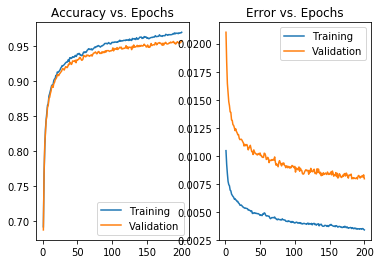

In [33]:
hidden = [200]

nn18 = NNClassifier(hidden, 200, 0.0005, 0.01,100)
nn18.train(train_X,train_y,valid_X,valid_y)
nn18.plot_training()

In [34]:
pred_y_test = nn18.pred(test_X)
print("Test set accuracy: ",calc_accuracy(test_y,pred_y_test))

Test set accuracy:  0.9554


{0: ['Train Accuracy = ', 0.5324791666666666, 'Valid Accuracy = ', 0.534]}
{1: ['Train Accuracy = ', 0.6522916666666667, 'Valid Accuracy = ', 0.6453333333333333]}
{2: ['Train Accuracy = ', 0.6890625, 'Valid Accuracy = ', 0.689]}
{3: ['Train Accuracy = ', 0.737125, 'Valid Accuracy = ', 0.7354166666666667]}
{4: ['Train Accuracy = ', 0.7376458333333333, 'Valid Accuracy = ', 0.7315]}
{5: ['Train Accuracy = ', 0.7629791666666667, 'Valid Accuracy = ', 0.76475]}
{6: ['Train Accuracy = ', 0.7765, 'Valid Accuracy = ', 0.77375]}
{7: ['Train Accuracy = ', 0.7864791666666666, 'Valid Accuracy = ', 0.7838333333333334]}
{8: ['Train Accuracy = ', 0.798, 'Valid Accuracy = ', 0.7999166666666667]}
{9: ['Train Accuracy = ', 0.8072708333333334, 'Valid Accuracy = ', 0.8066666666666666]}
{10: ['Train Accuracy = ', 0.8186666666666667, 'Valid Accuracy = ', 0.8173333333333334]}
{11: ['Train Accuracy = ', 0.8149791666666667, 'Valid Accuracy = ', 0.8165833333333333]}
{12: ['Train Accuracy = ', 0.8273958333333333,

{102: ['Train Accuracy = ', 0.9037916666666667, 'Valid Accuracy = ', 0.9005]}
{103: ['Train Accuracy = ', 0.9028125, 'Valid Accuracy = ', 0.8998333333333334]}
{104: ['Train Accuracy = ', 0.9033541666666667, 'Valid Accuracy = ', 0.9009166666666667]}
{105: ['Train Accuracy = ', 0.9015625, 'Valid Accuracy = ', 0.9013333333333333]}
{106: ['Train Accuracy = ', 0.9062083333333333, 'Valid Accuracy = ', 0.9035]}
{107: ['Train Accuracy = ', 0.9119166666666667, 'Valid Accuracy = ', 0.908]}
{108: ['Train Accuracy = ', 0.9086458333333334, 'Valid Accuracy = ', 0.9035]}
{109: ['Train Accuracy = ', 0.9095416666666667, 'Valid Accuracy = ', 0.9035]}
{110: ['Train Accuracy = ', 0.9026875, 'Valid Accuracy = ', 0.89825]}
{111: ['Train Accuracy = ', 0.9057291666666667, 'Valid Accuracy = ', 0.9039166666666667]}
{112: ['Train Accuracy = ', 0.9054791666666666, 'Valid Accuracy = ', 0.90225]}
{113: ['Train Accuracy = ', 0.9127916666666667, 'Valid Accuracy = ', 0.9064166666666666]}
{114: ['Train Accuracy = ', 0.

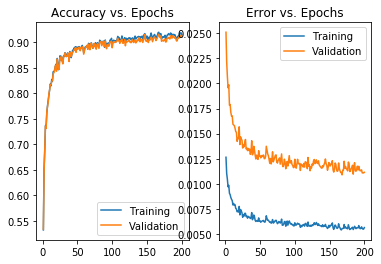

In [36]:
hidden = [25]

nn18 = NNClassifier(hidden, 200, 0.0005, 0.01,100)
nn18.train(train_X,train_y,valid_X,valid_y)
nn18.plot_training()

{0: ['Train Accuracy = ', 0.3386875, 'Valid Accuracy = ', 0.3451666666666667]}
{1: ['Train Accuracy = ', 0.47472916666666665, 'Valid Accuracy = ', 0.47758333333333336]}
{2: ['Train Accuracy = ', 0.57, 'Valid Accuracy = ', 0.5706666666666667]}
{3: ['Train Accuracy = ', 0.6353125, 'Valid Accuracy = ', 0.6354166666666666]}
{4: ['Train Accuracy = ', 0.6818541666666667, 'Valid Accuracy = ', 0.6783333333333333]}
{5: ['Train Accuracy = ', 0.721, 'Valid Accuracy = ', 0.7175833333333334]}
{6: ['Train Accuracy = ', 0.7401666666666666, 'Valid Accuracy = ', 0.7351666666666666]}
{7: ['Train Accuracy = ', 0.7691666666666667, 'Valid Accuracy = ', 0.7696666666666667]}
{8: ['Train Accuracy = ', 0.7777291666666667, 'Valid Accuracy = ', 0.7759166666666667]}
{9: ['Train Accuracy = ', 0.7860416666666666, 'Valid Accuracy = ', 0.7785]}
{10: ['Train Accuracy = ', 0.80425, 'Valid Accuracy = ', 0.8025833333333333]}
{11: ['Train Accuracy = ', 0.8127708333333333, 'Valid Accuracy = ', 0.8108333333333333]}
{12: ['T

{101: ['Train Accuracy = ', 0.9063125, 'Valid Accuracy = ', 0.9010833333333333]}
{102: ['Train Accuracy = ', 0.905125, 'Valid Accuracy = ', 0.9050833333333334]}
{103: ['Train Accuracy = ', 0.9076041666666667, 'Valid Accuracy = ', 0.90725]}
{104: ['Train Accuracy = ', 0.9076041666666667, 'Valid Accuracy = ', 0.9079166666666667]}
{105: ['Train Accuracy = ', 0.9035, 'Valid Accuracy = ', 0.9008333333333334]}
{106: ['Train Accuracy = ', 0.9014583333333334, 'Valid Accuracy = ', 0.897]}
{107: ['Train Accuracy = ', 0.9111666666666667, 'Valid Accuracy = ', 0.908]}
{108: ['Train Accuracy = ', 0.9030625, 'Valid Accuracy = ', 0.9004166666666666]}
{109: ['Train Accuracy = ', 0.9123125, 'Valid Accuracy = ', 0.9045833333333333]}
{110: ['Train Accuracy = ', 0.9037916666666667, 'Valid Accuracy = ', 0.8960833333333333]}
{111: ['Train Accuracy = ', 0.9075208333333333, 'Valid Accuracy = ', 0.9069166666666667]}
{112: ['Train Accuracy = ', 0.9020833333333333, 'Valid Accuracy = ', 0.89575]}
{113: ['Train Acc

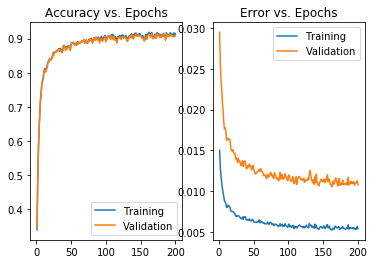

In [37]:
hidden = [25,15]

nn19 = NNClassifier(hidden, 200, 0.0005, 0.01,100)
nn19.train(train_X,train_y,valid_X,valid_y)
nn19.plot_training()

## Reference

[1] LeCun, Y. & Cortes, C. (2010). MNIST handwritten digit database. http://yann.lecun.com/exdb/mnist/

[2] Page 277, Shalev-Shwartz, S & Ben-David, S (2014). Understanding Machine Learning: From Theory to Algorithms

[3] Page 278, Shalev-Shwartz, S & Ben-David, S (2014). Understanding Machine Learning: From Theory to Algorithms

[4] Page 11, Srihari, S. Regularization in Neural Networks, CSE574. https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.5-Regularization.pdf